# Load data

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
SAVE_PATH = './output/test_data_checkpoint/test_data_partial.pt'

# Load train and validation data
data = torch.load(SAVE_PATH)
test_segments = data['segments']
test_labels = data['labels']

test_segments = np.array([segment.cpu().numpy() for segment in test_segments])
test_segments = np.transpose(test_segments, (0, 1, 3, 4, 2))
test_labels = test_labels.cpu().numpy().astype(int)
print(f"Train segments shape: {test_segments.shape}, Train labels shape: {test_labels.shape}")

/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_53557/4185903342.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(SAVE_PATH)


Train segments shape: (5282, 30, 128, 47, 1), Train labels shape: (5282,)


In [3]:

print(f"Test segments shape: {test_segments.shape}, Validation labels shape: {test_labels.shape}")

Test segments shape: (5282, 30, 128, 47, 1), Validation labels shape: (5282,)


# Evaluate

In [ ]:
# prompt: Load the keras model and yield evaluation metrics

from tensorflow.keras.models import load_model

# Example usage (assuming test_segments and test_labels are defined)
MODEL_PATH = 'output/best_model.keras' # Replace with the actual path
model = load_model(MODEL_PATH)

2024-12-01 16:41:49.277620: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-01 16:41:49.277656: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-01 16:41:49.277665: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-01 16:41:49.277897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 16:41:49.277912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-01 16:41:57.000729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


166/166 ━━━━━━━━━━━━━━━━━━━━ 48s 240ms/step - accuracy: 0.9784 - loss: 0.1001


In [8]:
# Generate predictions
y_pred = model.predict(test_segments)
y_pred_classes = (y_pred > 0.5).astype("int32")

166/166 ━━━━━━━━━━━━━━━━━━━━ 46s 221ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2641
           1       0.99      0.96      0.97      2641

    accuracy                           0.97      5282
   macro avg       0.97      0.97      0.97      5282
weighted avg       0.97      0.97      0.97      5282



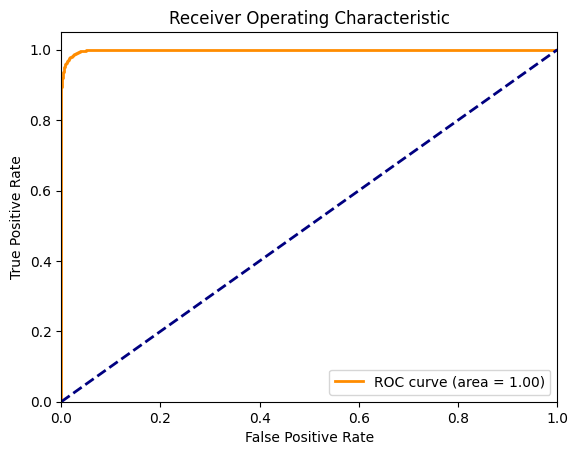

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
# Classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred_classes))

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

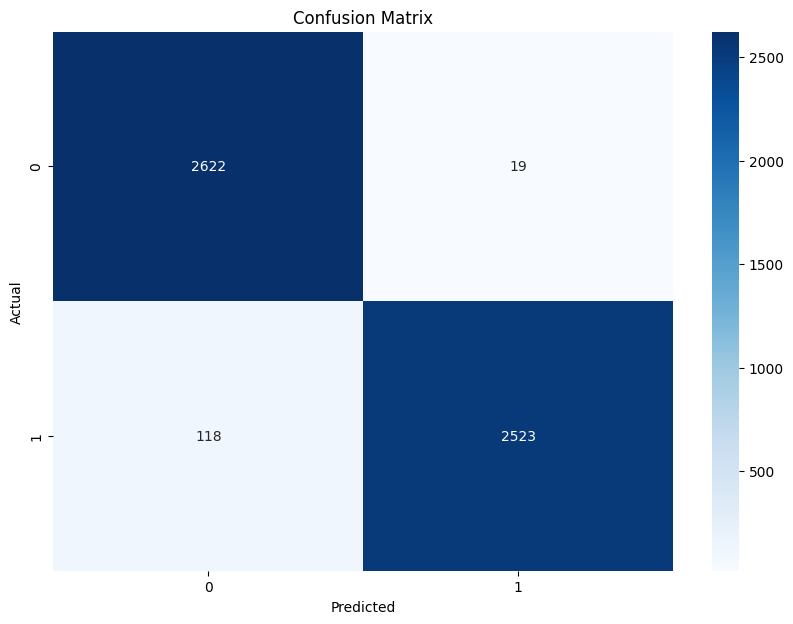

In [12]:
import seaborn as sns

conf_matrix = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()